In [1]:
# Load dependencies
import os
import re
import pycallingcards as cc
import scanpy as sc
import pandas as pd
#import scipy as sp
import numpy as np
from scipy import stats
from scipy.stats import norm
import scipy.sparse as sp
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import pybedtools
from typing import Optional, Literal
from appdirs import user_cache_dir
from urllib import request
import tempfile
#sets the figure DPI for the matplotlib plots
plt.rcParams['figure.dpi'] = 150

In [2]:
# Set working directory
cwd = os.getcwd()

In [3]:
# Read data as pandas dataframe
total_data = pd.read_csv("total_data.txt",sep = '\t',header= None)
total_data.columns = ['Chr','Start','End','Reads','Direction','Barcodes','SampleID','Score','group']
total_data

,Chr,Start,End,Reads,Direction,Barcodes,SampleID,Score,group
0,chr1,3025529,3025530,21,+,GAAG,16_7,2,mild
1,chr1,3036943,3036944,397,+,TCAG,2_2,8,severe
2,chr1,3048299,3048300,6,-,GTGT,16_7,2,mild
3,chr1,3060728,3060729,75,-,GAAG,14_5,3,mild
4,chr1,3060728,3060729,2,-,GTGT,6_5,8,severe
...,...,...,...,...,...,...,...,...,...
8238101,chrY,90811001,90811002,311,+,TTGG,2_2,8,severe
8238102,chrY,90811001,90811002,326,+,TCGA,2_2,8,severe
8238103,chrY,90811001,90811002,146,+,TGAC,9_5,8,severe
8238104,chrY,90811001,90811002,326,+,GAGA,11_1,8,severe


In [4]:
total_data_severe = total_data[total_data['group'] == 'severe']
total_data_severe = total_data_severe.reset_index(drop=True)
total_data_severe

,Chr,Start,End,Reads,Direction,Barcodes,SampleID,Score,group
0,chr1,3036943,3036944,397,+,TCAG,2_2,8,severe
1,chr1,3060728,3060729,2,-,GTGT,6_5,8,severe
2,chr1,3060728,3060729,112,-,GTGT,8_1,8,severe
3,chr1,3060870,3060871,130,+,TCGA,16_6,8,severe
4,chr1,3074767,3074768,5,+,ACAC,8_1,8,severe
...,...,...,...,...,...,...,...,...,...
3916318,chrY,90811001,90811002,311,+,TTGG,2_2,8,severe
3916319,chrY,90811001,90811002,326,+,TCGA,2_2,8,severe
3916320,chrY,90811001,90811002,146,+,TGAC,9_5,8,severe
3916321,chrY,90811001,90811002,326,+,GAGA,11_1,8,severe


In [5]:
total_data_mild = total_data[total_data['group'] == 'mild']
total_data_mild = total_data_mild.reset_index(drop=True)
total_data_mild

,Chr,Start,End,Reads,Direction,Barcodes,SampleID,Score,group
0,chr1,3025529,3025530,21,+,GAAG,16_7,2,mild
1,chr1,3048299,3048300,6,-,GTGT,16_7,2,mild
2,chr1,3060728,3060729,75,-,GAAG,14_5,3,mild
3,chr1,3060870,3060871,22,-,GTCA,4_3,2,mild
4,chr1,3074767,3074768,79,+,GAAG,4_3,2,mild
...,...,...,...,...,...,...,...,...,...
4321778,chrY,90811001,90811002,40,+,CAAC,4_3,2,mild
4321779,chrY,90811001,90811002,279,+,CTTC,1_5,2,mild
4321780,chrY,90811001,90811002,93,+,GCTA,5_1,3,mild
4321781,chrY,90811001,90811002,1838,+,TCAG,14_5,3,mild


In [6]:
# Flexible function to downsample datasets
def downsample_dataset(data, percentages=[90, 80, 70, 60, 50, 40, 30, 20], num_randomizations=3, random_seed=42):
    """
    Downsample a dataset to multiple percentages with multiple randomizations.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        The original dataset to downsample
    percentages : list
        List of percentages (as decimals) to downsample to
    num_randomizations : int
        Number of random downsamplings to perform for each percentage
    random_seed : int
        Base random seed to use (will be incremented for each randomization)
    
    Returns:
    --------
    dict
        A dictionary with keys as 'percentage_randomization' and values as downsampled dataframes
    """
    results = {}
    total_insertions = len(data)
    
    for percentage in percentages:
        # Calculate the number of insertions for this percentage
        sample_size = int(total_insertions * percentage)
        
        for rand_idx in range(1, num_randomizations + 1):
            # Create a unique random seed for each randomization
            current_seed = random_seed + rand_idx
            
            # Perform downsampling
            downsampled = cc.pp.down_sample(data, number=sample_size, random_state=current_seed)
            
            # Reset index
            downsampled = downsampled.reset_index(drop=True)
            
            # Create a descriptive key for the result
            key = f"{int(percentage*100)}_{rand_idx}"
            
            # Store the result
            results[key] = downsampled
            
            print(f"Downsampled to {percentage*100}% ({sample_size} insertions), randomization #{rand_idx}, shape: {downsampled.shape}")
    
    return results

In [7]:
# For mild dataset
mild_downsamplings = downsample_dataset(total_data_mild, 
                                       percentages=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2], 
                                       num_randomizations=3, 
                                       random_seed=1)

Downsampled to 90.0% (3889604 insertions), randomization #1, shape: (3889604, 9)
Downsampled to 90.0% (3889604 insertions), randomization #2, shape: (3889604, 9)
Downsampled to 90.0% (3889604 insertions), randomization #3, shape: (3889604, 9)
Downsampled to 80.0% (3457426 insertions), randomization #1, shape: (3457426, 9)
Downsampled to 80.0% (3457426 insertions), randomization #2, shape: (3457426, 9)
Downsampled to 80.0% (3457426 insertions), randomization #3, shape: (3457426, 9)
Downsampled to 70.0% (3025248 insertions), randomization #1, shape: (3025248, 9)
Downsampled to 70.0% (3025248 insertions), randomization #2, shape: (3025248, 9)
Downsampled to 70.0% (3025248 insertions), randomization #3, shape: (3025248, 9)
Downsampled to 60.0% (2593069 insertions), randomization #1, shape: (2593069, 9)
Downsampled to 60.0% (2593069 insertions), randomization #2, shape: (2593069, 9)
Downsampled to 60.0% (2593069 insertions), randomization #3, shape: (2593069, 9)
Downsampled to 50.0% (216089

In [8]:
# For severe dataset
severe_downsamplings = downsample_dataset(total_data_severe, 
                                         percentages=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2], 
                                         num_randomizations=3, 
                                         random_seed=1)  # Use the same base seed as mild

Downsampled to 90.0% (3524690 insertions), randomization #1, shape: (3524690, 9)
Downsampled to 90.0% (3524690 insertions), randomization #2, shape: (3524690, 9)
Downsampled to 90.0% (3524690 insertions), randomization #3, shape: (3524690, 9)
Downsampled to 80.0% (3133058 insertions), randomization #1, shape: (3133058, 9)
Downsampled to 80.0% (3133058 insertions), randomization #2, shape: (3133058, 9)
Downsampled to 80.0% (3133058 insertions), randomization #3, shape: (3133058, 9)
Downsampled to 70.0% (2741426 insertions), randomization #1, shape: (2741426, 9)
Downsampled to 70.0% (2741426 insertions), randomization #2, shape: (2741426, 9)
Downsampled to 70.0% (2741426 insertions), randomization #3, shape: (2741426, 9)
Downsampled to 60.0% (2349793 insertions), randomization #1, shape: (2349793, 9)
Downsampled to 60.0% (2349793 insertions), randomization #2, shape: (2349793, 9)
Downsampled to 60.0% (2349793 insertions), randomization #3, shape: (2349793, 9)
Downsampled to 50.0% (195816

In [9]:
# Access specific downsampled dataframes
mild_downsamplings['90_1']

,Chr,Start,End,Reads,Direction,Barcodes,SampleID,Score,group
0,chr1,3025529,3025530,21,+,GAAG,16_7,2,mild
1,chr1,3048299,3048300,6,-,GTGT,16_7,2,mild
2,chr1,3060728,3060729,75,-,GAAG,14_5,3,mild
3,chr1,3060870,3060871,22,-,GTCA,4_3,2,mild
4,chr1,3074767,3074768,79,+,GAAG,4_3,2,mild
...,...,...,...,...,...,...,...,...,...
3889599,chrY,90811001,90811002,18,+,GGAA,4_3,2,mild
3889600,chrY,90811001,90811002,1838,+,TCAG,14_5,3,mild
3889601,chrY,90811001,90811002,279,+,CTTC,1_5,2,mild
3889602,chrY,90811001,90811002,36,+,CTTC,4_3,2,mild


In [9]:
# Function to combine corresponding mild and severe downsampled qbeds
def combine_all_downsamplings(mild_dict, severe_dict, percentages=[90, 80, 70, 60, 50, 40, 30, 20], num_randomizations=3):
    """
    Combine corresponding mild and severe downsampled datasets
    
    Parameters:
    -----------
    mild_dict : dict
        Dictionary of downsampled mild datasets
    severe_dict : dict
        Dictionary of downsampled severe datasets
    percentages : list
        List of percentage values
    num_randomizations : int
        Number of randomizations per percentage
    
    Returns:
    --------
    dict
        Dictionary of combined datasets with the same keys
    """
    combined_dict = {}
    
    for percentage in percentages:
        for rand_idx in range(1, num_randomizations + 1):
            # Create the key
            key = f"{percentage}_{rand_idx}"
            
            try:
                # Combine the corresponding datasets
                combined = cc.rd.combine_qbed([mild_dict[key], severe_dict[key]])
                combined_dict[key] = combined
                print(f"Combined {key}: {len(combined)} insertions")
            except KeyError as e:
                print(f"Error combining {key}: {e}")
    
    return combined_dict

In [10]:
# Use the function to combine all your downsampled datasets
combined_downsamplings = combine_all_downsamplings(
    mild_downsamplings, 
    severe_downsamplings,
    percentages=[90, 80, 70, 60, 50, 40, 30, 20],
    num_randomizations=3
)

Combined 90_1: 7414294 insertions
Combined 90_2: 7414294 insertions
Combined 90_3: 7414294 insertions
Combined 80_1: 6590484 insertions
Combined 80_2: 6590484 insertions
Combined 80_3: 6590484 insertions
Combined 70_1: 5766674 insertions
Combined 70_2: 5766674 insertions
Combined 70_3: 5766674 insertions
Combined 60_1: 4942862 insertions
Combined 60_2: 4942862 insertions
Combined 60_3: 4942862 insertions
Combined 50_1: 4119052 insertions
Combined 50_2: 4119052 insertions
Combined 50_3: 4119052 insertions
Combined 40_1: 3295242 insertions
Combined 40_2: 3295242 insertions
Combined 40_3: 3295242 insertions
Combined 30_1: 2471430 insertions
Combined 30_2: 2471430 insertions
Combined 30_3: 2471430 insertions
Combined 20_1: 1647620 insertions
Combined 20_2: 1647620 insertions
Combined 20_3: 1647620 insertions


In [12]:
# Now you can access any combined dataset
combined_downsamplings['90_1']
#total_data_40_3 = combined_downsamplings['40_3']

,Chr,Start,End,Reads,Direction,Barcodes,SampleID,Score,group
0,chr1,3025529,3025530,21,+,GAAG,16_7,2,mild
1,chr1,3036943,3036944,397,+,TCAG,2_2,8,severe
2,chr1,3048299,3048300,6,-,GTGT,16_7,2,mild
3,chr1,3060728,3060729,75,-,GAAG,14_5,3,mild
4,chr1,3060728,3060729,112,-,GTGT,8_1,8,severe
...,...,...,...,...,...,...,...,...,...
7414289,chrY,90811001,90811002,326,+,GAGA,11_1,8,severe
7414290,chrY,90811001,90811002,299,+,GTTG,2_2,8,severe
7414291,chrY,90811001,90811002,311,+,TTGG,2_2,8,severe
7414292,chrY,90811001,90811002,186,+,GGAA,2_2,8,severe


In [11]:
uploaded_peaks = cc.rd.read_qbed("peaks.bed")
uploaded_peaks

,Chr,Start,End,Reads,Direction,Barcodes
0,chr1,3245070,3247104,NaN,NaN,NaN
1,chr1,3296871,3300418,NaN,NaN,NaN
2,chr1,3309788,3310809,NaN,NaN,NaN
3,chr1,3319892,3324705,NaN,NaN,NaN
4,chr1,3365567,3372481,NaN,NaN,NaN
...,...,...,...,...,...,...
16867,chrX,169810037,169813700,NaN,NaN,NaN
16868,chrX,169922506,169926762,NaN,NaN,NaN
16869,chrX,169928521,169932808,NaN,NaN,NaN
16870,chrX,169979401,169985593,NaN,NaN,NaN


In [12]:
# Make a group by peak Anndata object

def create_anndata_objects(combined_dict, uploaded_peaks, sample_ids, percentages=[90, 80, 70, 60, 50, 40, 30, 20], num_randomizations=3):
    """
    Create anndata objects for all combined downsampled datasets
    
    Parameters:
    -----------
    combined_dict : dict
        Dictionary of combined datasets (mild + severe)
    uploaded_peaks : object
        The peaks object needed for cc.pp.make_Anndata
    sample_ids : list
        List of sample IDs to use in the same order
    percentages : list
        List of percentage values
    num_randomizations : int
        Number of randomizations per percentage
    
    Returns:
    --------
    dict
        Dictionary of anndata objects with keys like '80_1', '60_2', etc.
    """
    # Define the mild and severe group labels
    mild_samples = ["mild"] * 10  # First 10 samples are mild
    severe_samples = ["severe"] * 10  # Last 10 samples are severe
    group_labels = np.array(mild_samples + severe_samples)
    
    anndata_dict = {}
    
    for percentage in percentages:
        for rand_idx in range(1, num_randomizations + 1):
            # Create the key
            key = f"{percentage}_{rand_idx}"
            
            try:
                # Get the combined dataset
                combined_data = combined_dict[key]
                
                # Create anndata object
                adata = cc.pp.make_Anndata(
                    combined_data, 
                    uploaded_peaks, 
                    sample_ids, 
                    key='SampleID'
                )
                
                # Add group labels
                adata.obs["group"] = group_labels
                
                # Store the anndata object
                anndata_dict[key] = adata
                
                print(f"Created anndata for {key}: {adata.shape}")
            except KeyError as e:
                print(f"Error creating anndata for {key}: {e}")
            except Exception as e:
                print(f"Other error for {key}: {e}")
    
    return anndata_dict

In [13]:
# Define your sample IDs - these are the same for all datasets
sample_ids = ['9_4', '3_2', '5_2', '4_3', '1_5', '4_2', '5_1', '16_7', '14_5', '15_7',
              '7_4', '5_5', '6_5', '3_1', '2_2', '9_5', '8_1', '11_1', '11_5', '16_6']

In [24]:
# Create anndata objects for all combined datasets
anndata_objects = create_anndata_objects(
    combined_downsamplings,
    uploaded_peaks,
    sample_ids,
    percentages=[90, 80, 70, 60, 50, 40, 30, 20],
    num_randomizations=3
)

100%|██████████| 21/21 [00:52<00:00,  2.48s/it]


Created anndata for 90_1: (20, 16872)


100%|██████████| 21/21 [00:53<00:00,  2.57s/it]


Created anndata for 90_2: (20, 16872)


100%|██████████| 21/21 [00:55<00:00,  2.63s/it]


Created anndata for 90_3: (20, 16872)


100%|██████████| 21/21 [00:48<00:00,  2.30s/it]


Created anndata for 80_1: (20, 16872)


100%|██████████| 21/21 [00:54<00:00,  2.61s/it]


Created anndata for 80_2: (20, 16872)


100%|██████████| 21/21 [00:48<00:00,  2.31s/it]


Created anndata for 80_3: (20, 16872)


100%|██████████| 21/21 [00:42<00:00,  2.02s/it]


Created anndata for 70_1: (20, 16872)


100%|██████████| 21/21 [00:42<00:00,  2.04s/it]


Created anndata for 70_2: (20, 16872)


100%|██████████| 21/21 [00:43<00:00,  2.09s/it]


Created anndata for 70_3: (20, 16872)


100%|██████████| 21/21 [00:38<00:00,  1.82s/it]


Created anndata for 60_1: (20, 16872)


100%|██████████| 21/21 [00:38<00:00,  1.84s/it]


Created anndata for 60_2: (20, 16872)


100%|██████████| 21/21 [00:38<00:00,  1.84s/it]


Created anndata for 60_3: (20, 16872)


100%|██████████| 21/21 [00:30<00:00,  1.45s/it]


Created anndata for 50_1: (20, 16872)


100%|██████████| 21/21 [00:31<00:00,  1.48s/it]


Created anndata for 50_2: (20, 16872)


100%|██████████| 21/21 [00:32<00:00,  1.56s/it]


Created anndata for 50_3: (20, 16872)


100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Created anndata for 40_1: (20, 16872)


100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Created anndata for 40_2: (20, 16872)


100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Created anndata for 40_3: (20, 16872)


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Created anndata for 30_1: (20, 16872)


100%|██████████| 21/21 [00:18<00:00,  1.13it/s]


Created anndata for 30_2: (20, 16872)


100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


Created anndata for 30_3: (20, 16872)


100%|██████████| 21/21 [00:16<00:00,  1.28it/s]


Created anndata for 20_1: (20, 16872)


100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


Created anndata for 20_2: (20, 16872)


100%|██████████| 21/21 [00:12<00:00,  1.74it/s]

Created anndata for 20_3: (20, 16872)


In [ ]:
# Now you can access any anndata object
adata_cc_80_1 = anndata_objects['80_1']
adata_cc_60_2 = anndata_objects['60_2']
adata_cc_40_3 = anndata_objects['40_3']

In [32]:
anndata_objects['90_1'].uns

OrderedDict([('fisher_exact',
              {'params': {'groupby': 'group',
                'reference': 'rest',
                'method': 'fisher_exact'}})])

In [28]:
# Function for fisher exact test on all downsampled datasets
def analyze_differential_peaks(anndata_dict, percentages=[90, 80, 70, 60, 50, 40, 30, 20], num_randomizations=3):
    """
    Run Fisher's exact test on all downsampled datasets, save results, and count significant peaks
    
    Parameters:
    -----------
    anndata_dict : dict
        Dictionary of anndata objects
    percentages : list
        List of percentage values
    num_randomizations : int
        Number of randomizations per percentage
    
    Returns:
    --------
    dict
        Dictionary with counts of significant peaks for each dataset
    """
    significant_peaks = {}
    
    for percentage in percentages:
        for rand_idx in range(1, num_randomizations + 1):
            key = f"{percentage}_{rand_idx}"
            
            try:
                print(f"\nProcessing dataset {key}...")
                
                # Get the anndata object
                adata = anndata_dict[key]
                
                # Run Fisher's exact test
                print(f"Running Fisher's exact test for {key}...")
                cc.tl.rank_peak_groups(adata, "group", method='fisher_exact', key_added='fisher_exact', by="sample")
                
                # Create visualization
                print(f"Creating rank plot for {key}...")
                cc.pl.rank_peak_groups(adata, key='fisher_exact', rankby='pvalues')
                
                # Get differential peaks data and set index
                dedata = cc.tl.rank_peak_groups_df(adata, 'fisher_exact')
                dedata = dedata.set_index(['names'])
                
                # Concatenate results to the anndata var attribute
                adata.var = pd.concat([adata.var, dedata[(dedata['group'] == 'severe')]], axis=1)
                
                # Get insertion counts (transpose of X matrix)
                print(f"Processing insertion counts for {key}...")
                if sp.issparse(adata.X):
                    array_T = adata.X.toarray().T  # Convert sparse matrix to dense and transpose
                else:
                    array_T = adata.X.T  # Transpose the dense matrix
                
                # Create DataFrame with proper index and column names
                array_df = pd.DataFrame(
                    array_T, 
                    index=adata.var_names,  # Peak names as index
                    columns=adata.obs_names  # Sample names as columns
                )
                
                # Add counts to var attribute
                adata.var = pd.concat([adata.var, array_df], axis=1)
                
                # Write results to file
                output_file = os.path.join('Downsampling', f'fisher_{key}.csv')
                print(f"Saving results to {output_file}...")
                adata.var.to_csv(output_file)
                
                # Count significant peaks
                sig_count = sum(adata.var['pvalues_adj'] < 0.05)
                significant_peaks[key] = sig_count
                print(f"{key}: {sig_count} peaks with adj p-value < 0.05")
                
            except Exception as e:
                print(f"Error processing {key}: {e}")
    
    return significant_peaks


Processing dataset 90_1...
Running Fisher's exact test for 90_1...


100%|██████████| 2/2 [02:34<00:00, 77.39s/it]


Creating rank plot for 90_1...


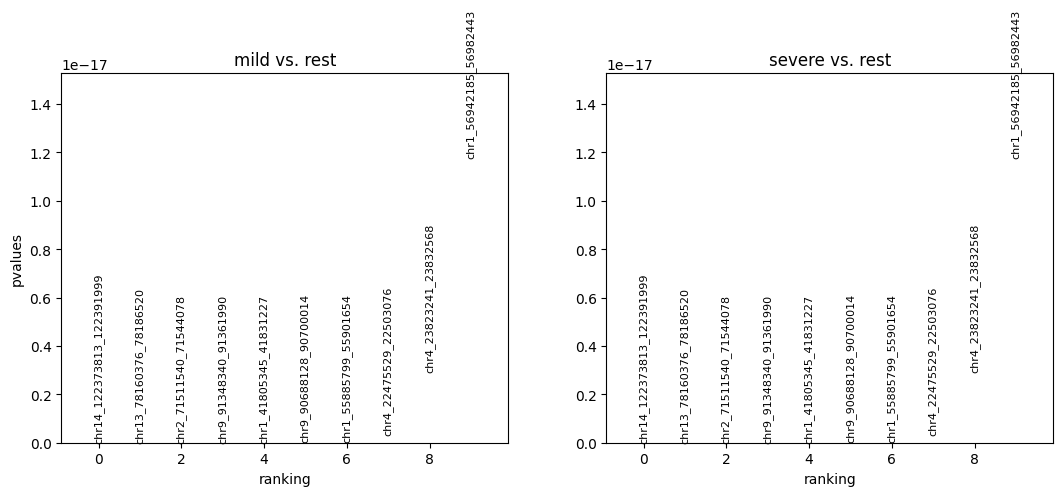

Processing insertion counts for 90_1...
Saving results to Downsampling/fisher_90_1.csv...
90_1: 223 peaks with adj p-value < 0.05

Processing dataset 90_2...
Running Fisher's exact test for 90_2...


100%|██████████| 2/2 [02:27<00:00, 73.74s/it]


Creating rank plot for 90_2...


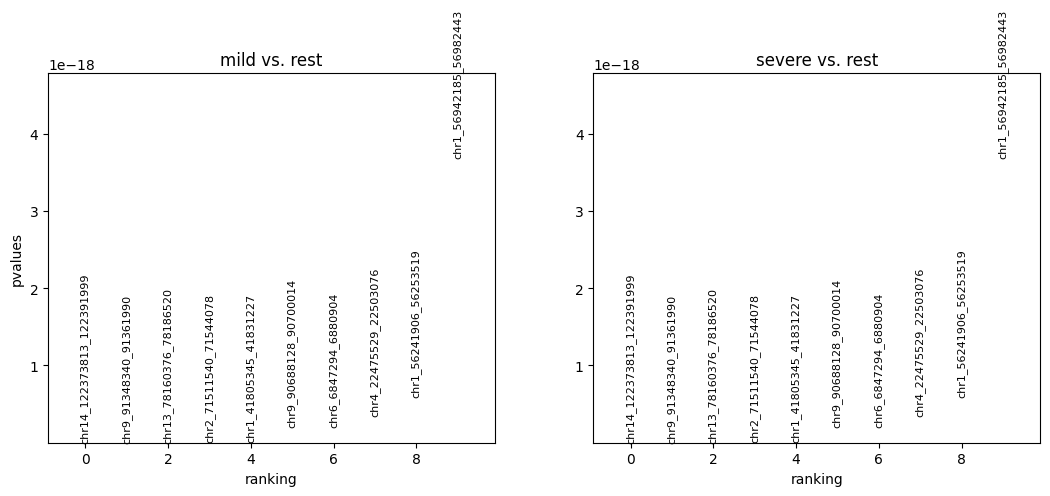

Processing insertion counts for 90_2...
Saving results to Downsampling/fisher_90_2.csv...
90_2: 202 peaks with adj p-value < 0.05

Processing dataset 90_3...
Running Fisher's exact test for 90_3...


100%|██████████| 2/2 [02:27<00:00, 73.83s/it]


Creating rank plot for 90_3...


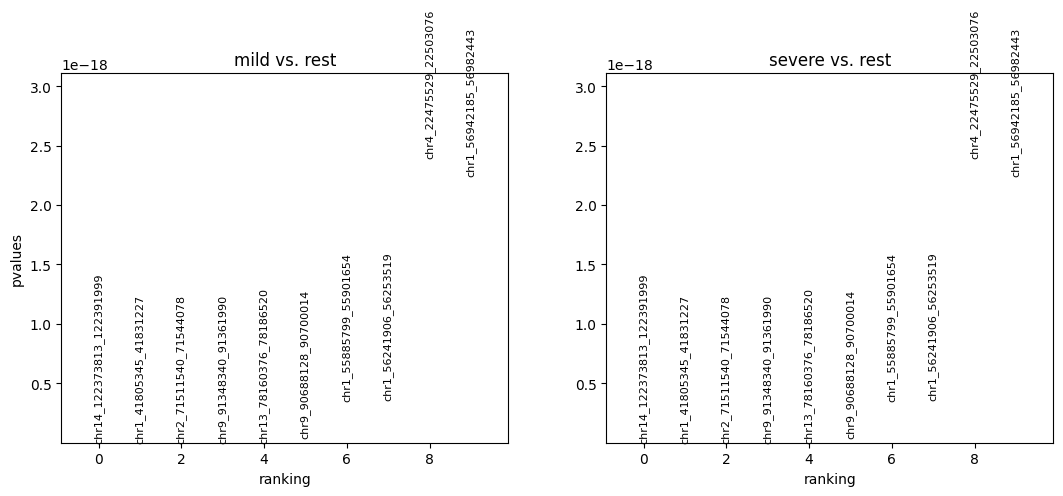

Processing insertion counts for 90_3...
Saving results to Downsampling/fisher_90_3.csv...
90_3: 210 peaks with adj p-value < 0.05

Processing dataset 80_1...
Running Fisher's exact test for 80_1...


100%|██████████| 2/2 [02:29<00:00, 74.85s/it]


Creating rank plot for 80_1...


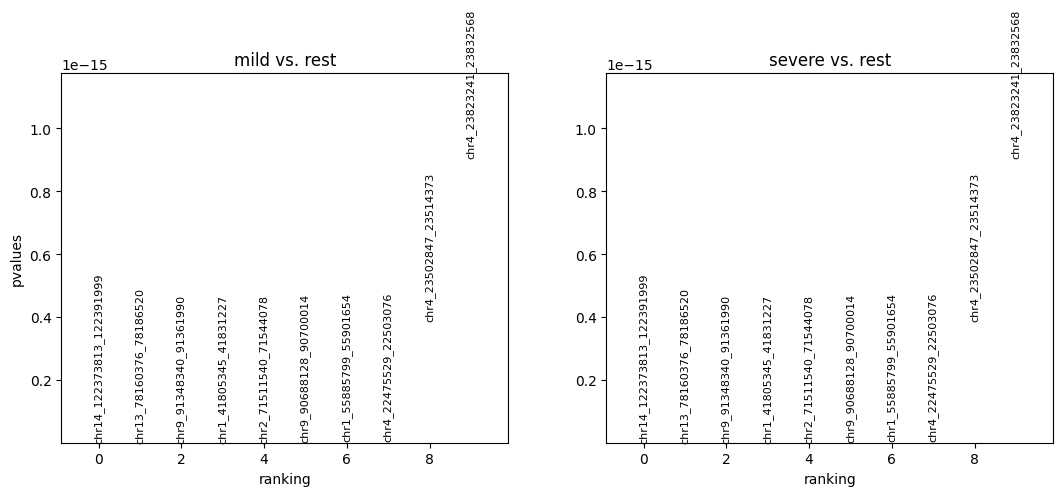

Processing insertion counts for 80_1...
Saving results to Downsampling/fisher_80_1.csv...
80_1: 170 peaks with adj p-value < 0.05

Processing dataset 80_2...
Running Fisher's exact test for 80_2...


100%|██████████| 2/2 [02:06<00:00, 63.34s/it]


Creating rank plot for 80_2...


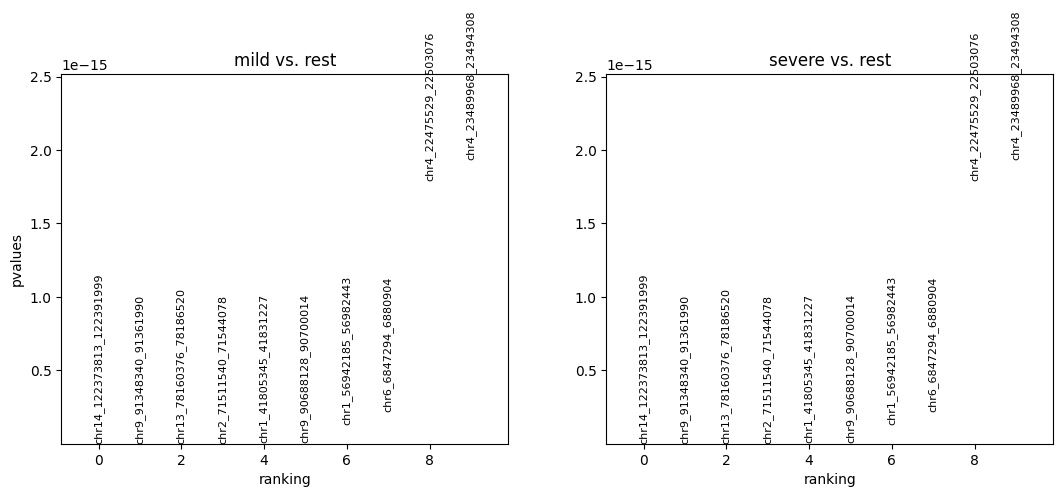

Processing insertion counts for 80_2...
Saving results to Downsampling/fisher_80_2.csv...
80_2: 179 peaks with adj p-value < 0.05

Processing dataset 80_3...
Running Fisher's exact test for 80_3...


100%|██████████| 2/2 [02:04<00:00, 62.00s/it]


Creating rank plot for 80_3...


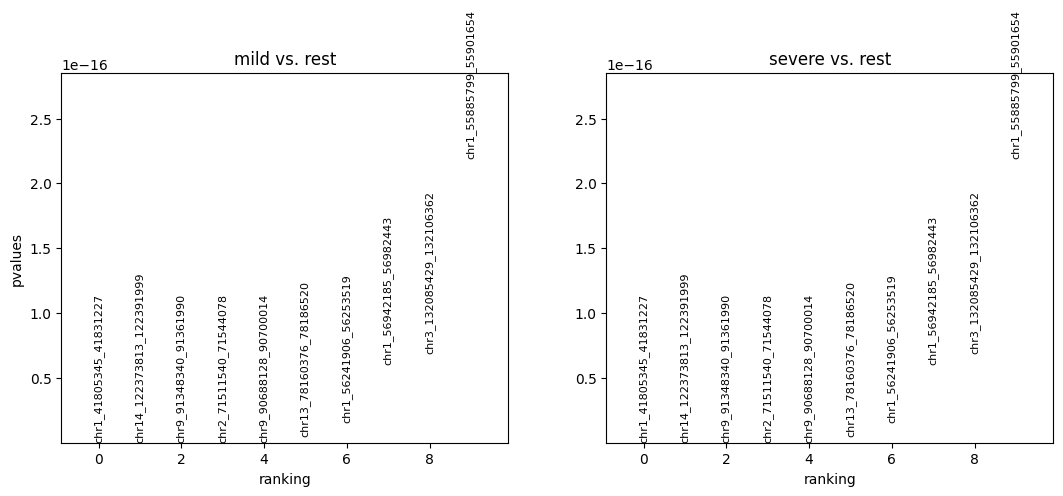

Processing insertion counts for 80_3...
Saving results to Downsampling/fisher_80_3.csv...
80_3: 166 peaks with adj p-value < 0.05

Processing dataset 70_1...
Running Fisher's exact test for 70_1...


100%|██████████| 2/2 [02:04<00:00, 62.30s/it]


Creating rank plot for 70_1...


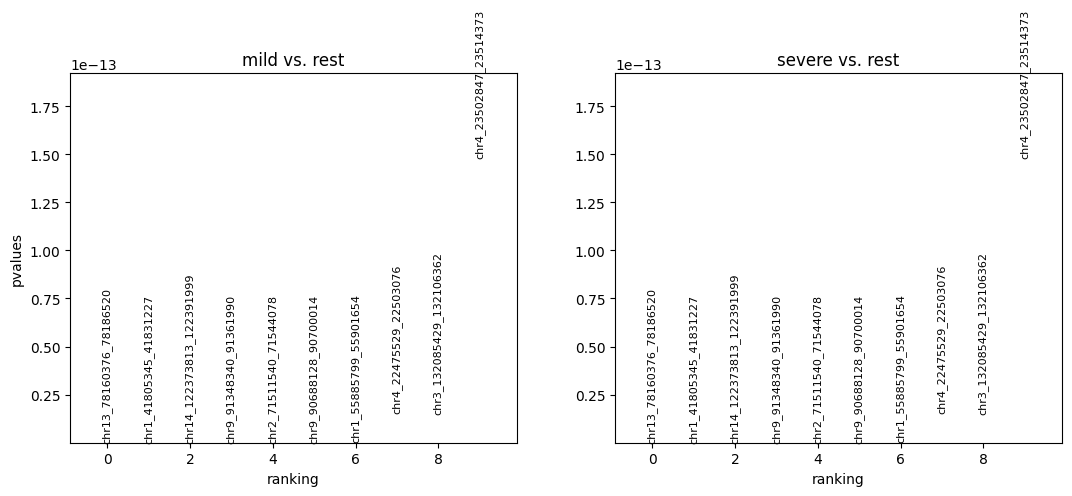

Processing insertion counts for 70_1...
Saving results to Downsampling/fisher_70_1.csv...
70_1: 138 peaks with adj p-value < 0.05

Processing dataset 70_2...
Running Fisher's exact test for 70_2...


100%|██████████| 2/2 [02:02<00:00, 61.38s/it]


Creating rank plot for 70_2...


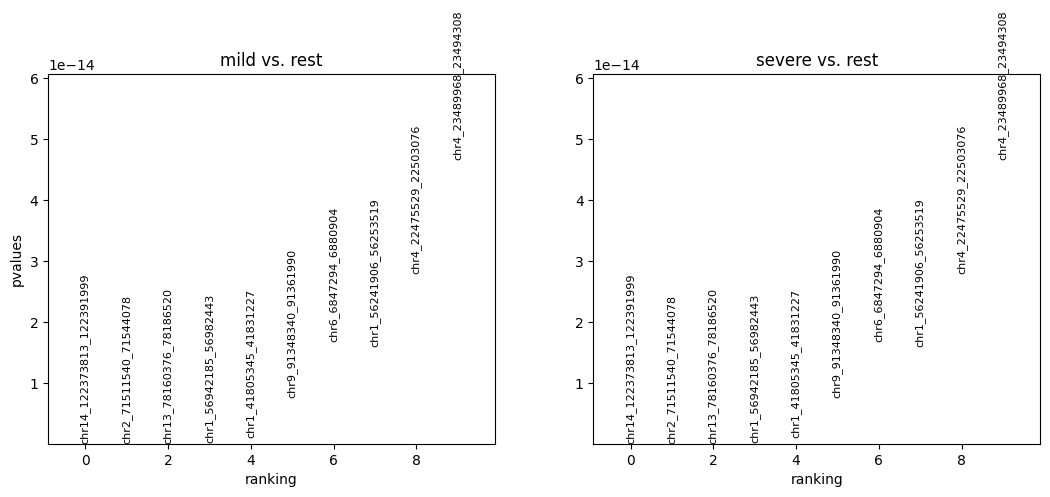

Processing insertion counts for 70_2...
Saving results to Downsampling/fisher_70_2.csv...
70_2: 117 peaks with adj p-value < 0.05

Processing dataset 70_3...
Running Fisher's exact test for 70_3...


100%|██████████| 2/2 [02:01<00:00, 60.64s/it]


Creating rank plot for 70_3...


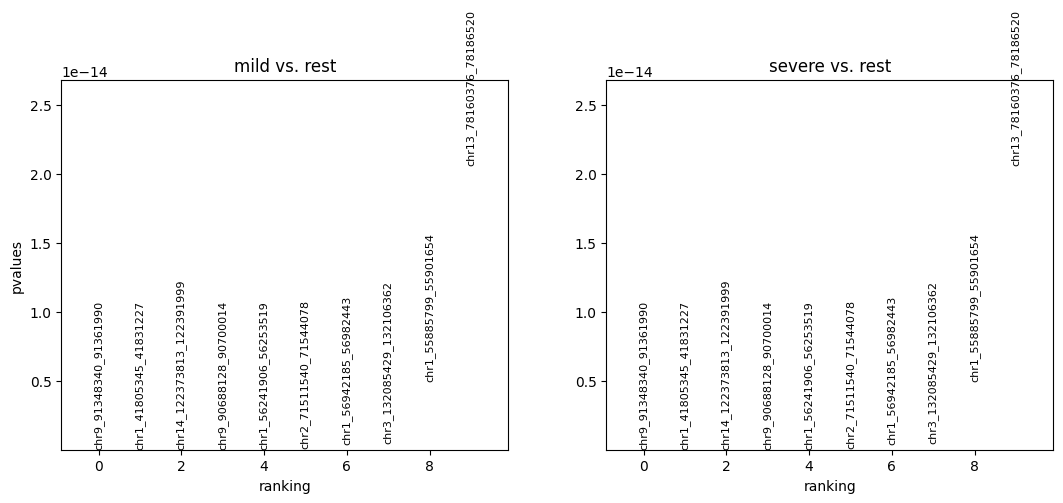

Processing insertion counts for 70_3...
Saving results to Downsampling/fisher_70_3.csv...
70_3: 111 peaks with adj p-value < 0.05

Processing dataset 60_1...
Running Fisher's exact test for 60_1...


100%|██████████| 2/2 [01:58<00:00, 59.25s/it]


Creating rank plot for 60_1...


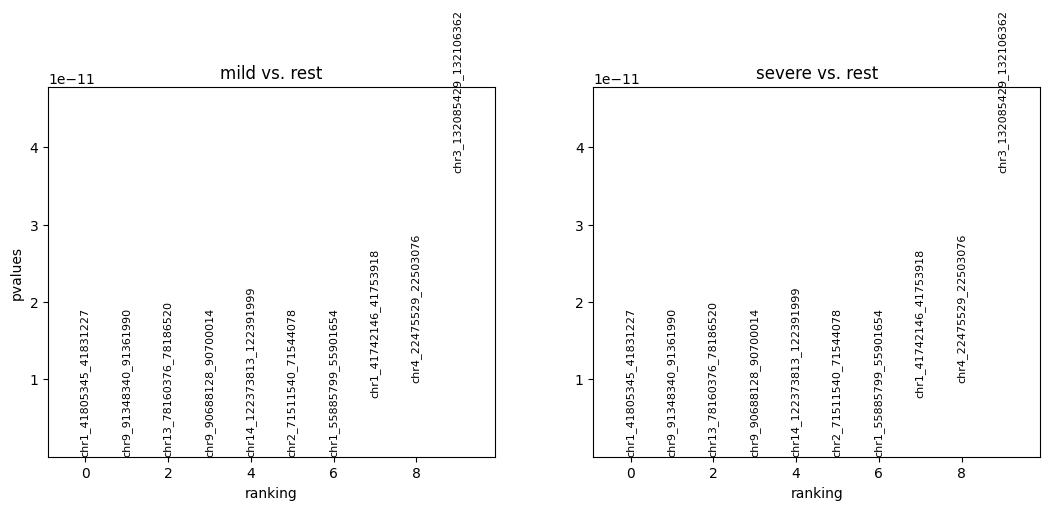

Processing insertion counts for 60_1...
Saving results to Downsampling/fisher_60_1.csv...
60_1: 100 peaks with adj p-value < 0.05

Processing dataset 60_2...
Running Fisher's exact test for 60_2...


100%|██████████| 2/2 [02:01<00:00, 60.68s/it]


Creating rank plot for 60_2...


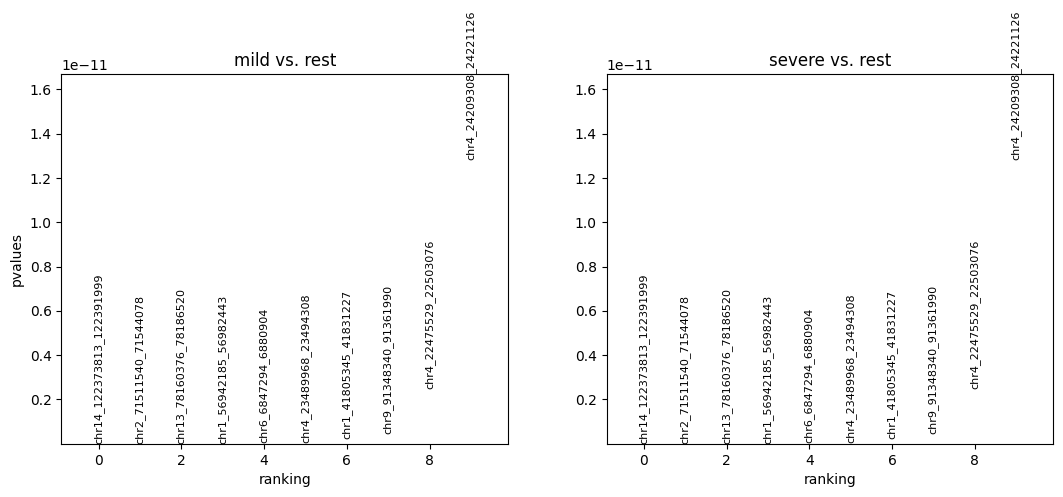

Processing insertion counts for 60_2...
Saving results to Downsampling/fisher_60_2.csv...
60_2: 91 peaks with adj p-value < 0.05

Processing dataset 60_3...
Running Fisher's exact test for 60_3...


100%|██████████| 2/2 [01:58<00:00, 59.40s/it]


Creating rank plot for 60_3...


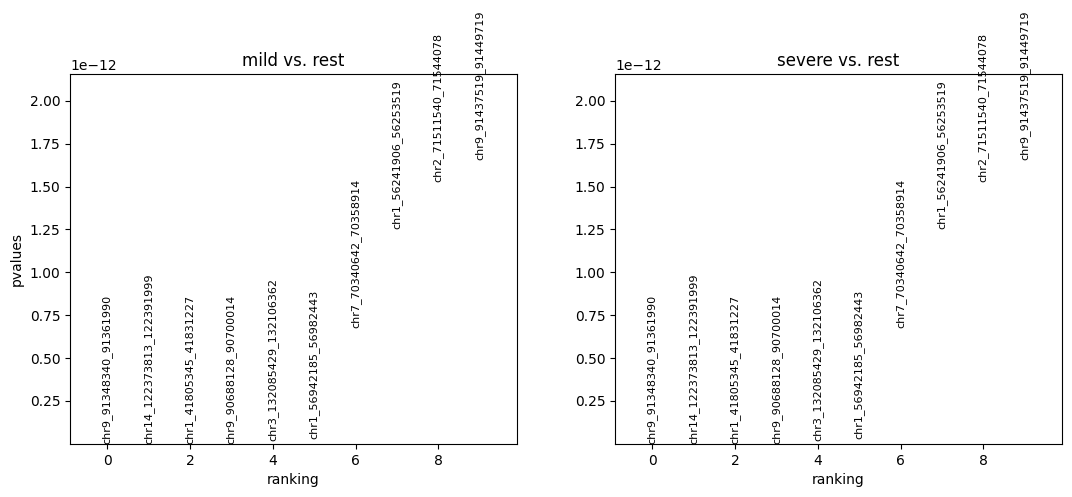

Processing insertion counts for 60_3...
Saving results to Downsampling/fisher_60_3.csv...
60_3: 86 peaks with adj p-value < 0.05

Processing dataset 50_1...
Running Fisher's exact test for 50_1...


100%|██████████| 2/2 [02:11<00:00, 65.94s/it]


Creating rank plot for 50_1...


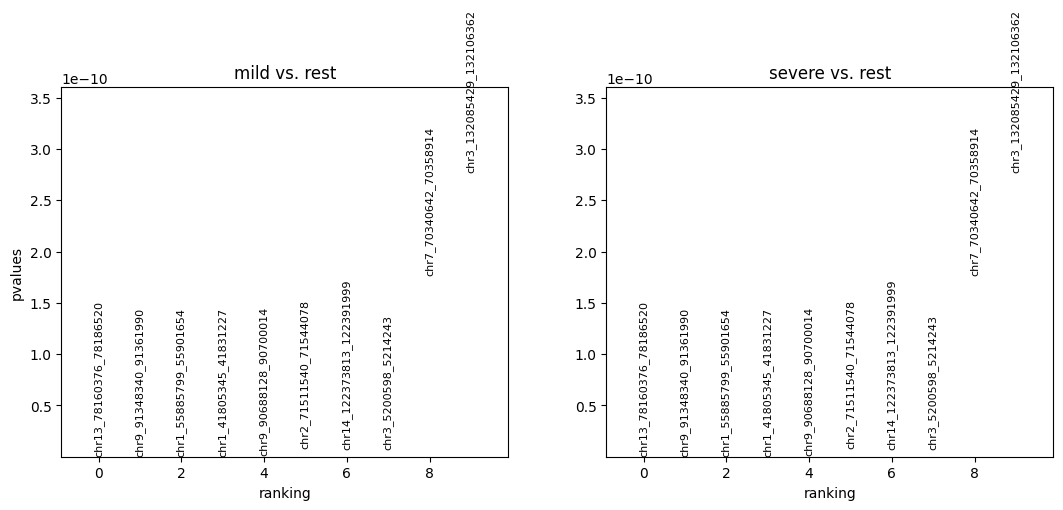

Processing insertion counts for 50_1...
Saving results to Downsampling/fisher_50_1.csv...
50_1: 82 peaks with adj p-value < 0.05

Processing dataset 50_2...
Running Fisher's exact test for 50_2...


100%|██████████| 2/2 [02:17<00:00, 68.59s/it]


Creating rank plot for 50_2...


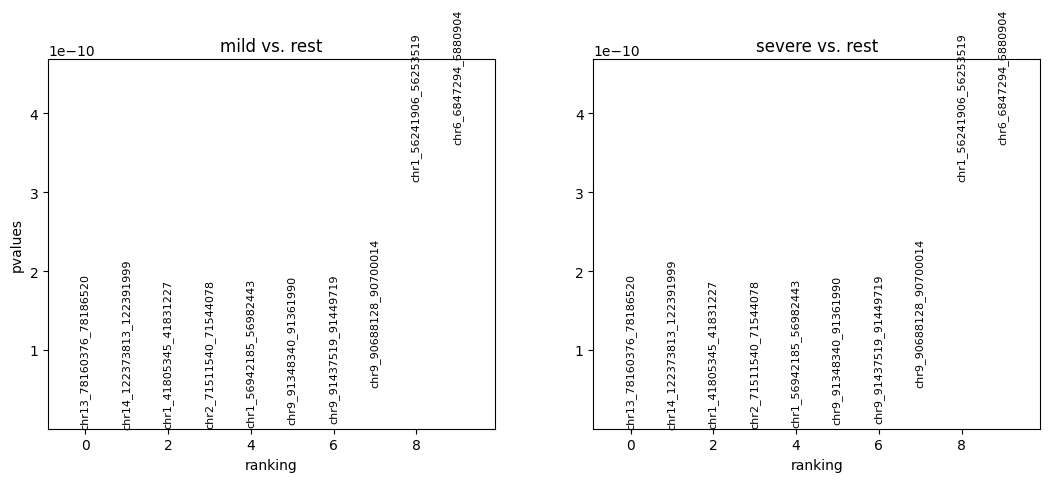

Processing insertion counts for 50_2...
Saving results to Downsampling/fisher_50_2.csv...
50_2: 71 peaks with adj p-value < 0.05

Processing dataset 50_3...
Running Fisher's exact test for 50_3...


100%|██████████| 2/2 [02:20<00:00, 70.28s/it]


Creating rank plot for 50_3...


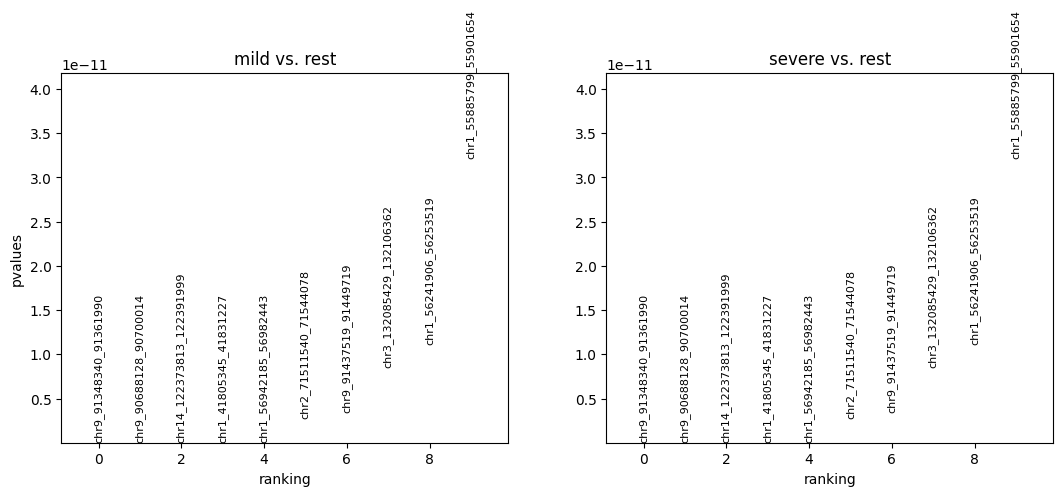

Processing insertion counts for 50_3...
Saving results to Downsampling/fisher_50_3.csv...
50_3: 65 peaks with adj p-value < 0.05

Processing dataset 40_1...
Running Fisher's exact test for 40_1...


100%|██████████| 2/2 [02:15<00:00, 67.82s/it]


Creating rank plot for 40_1...


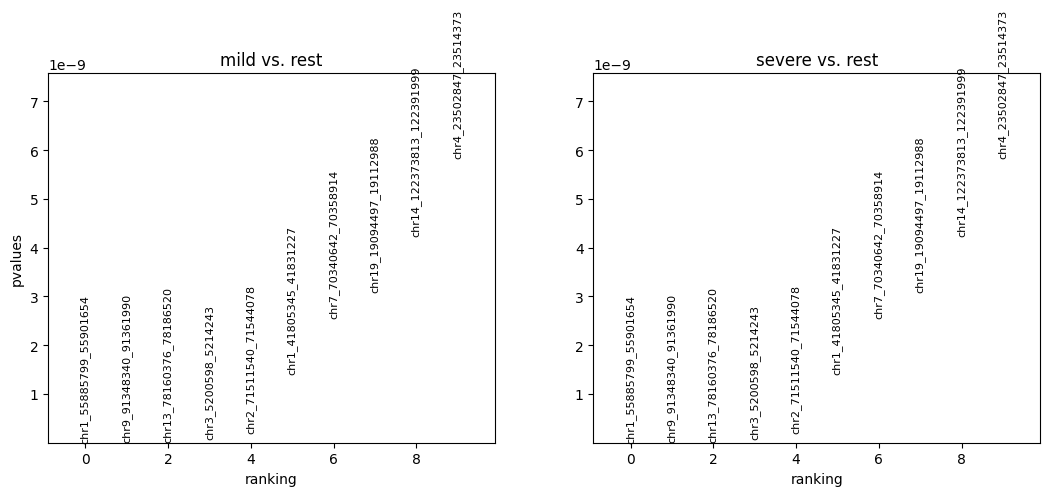

Processing insertion counts for 40_1...
Saving results to Downsampling/fisher_40_1.csv...
40_1: 49 peaks with adj p-value < 0.05

Processing dataset 40_2...
Running Fisher's exact test for 40_2...


100%|██████████| 2/2 [02:17<00:00, 68.92s/it]


Creating rank plot for 40_2...


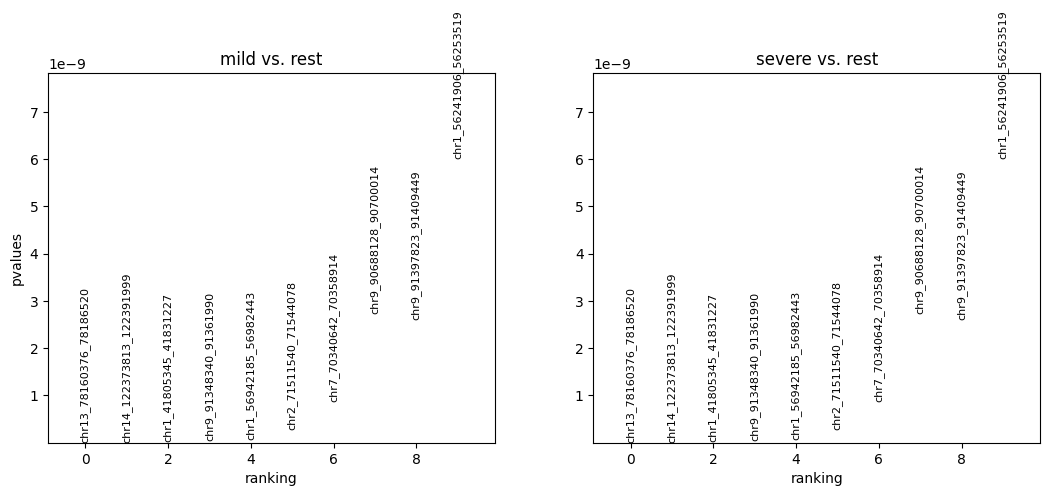

Processing insertion counts for 40_2...
Saving results to Downsampling/fisher_40_2.csv...
40_2: 43 peaks with adj p-value < 0.05

Processing dataset 40_3...
Running Fisher's exact test for 40_3...


100%|██████████| 2/2 [02:17<00:00, 68.65s/it]


Creating rank plot for 40_3...


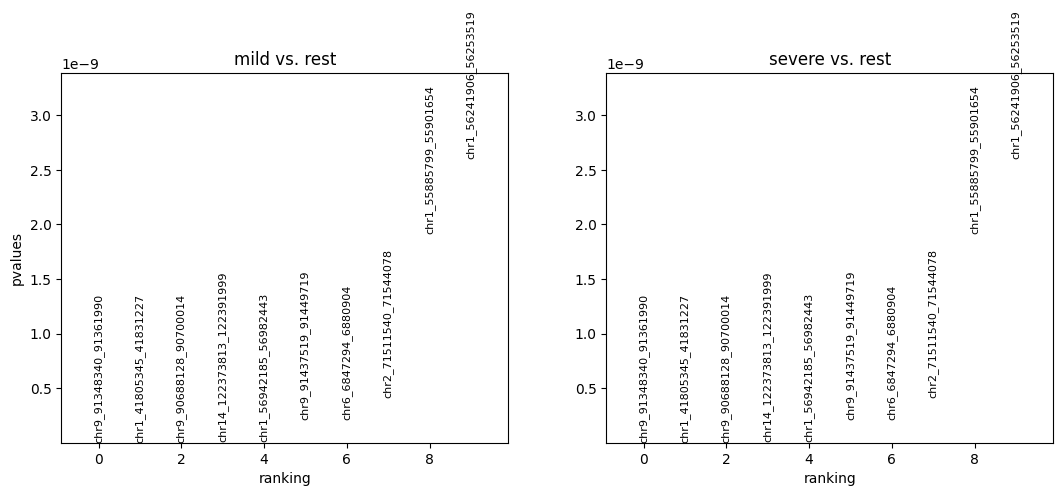

Processing insertion counts for 40_3...
Saving results to Downsampling/fisher_40_3.csv...
40_3: 37 peaks with adj p-value < 0.05

Processing dataset 30_1...
Running Fisher's exact test for 30_1...


100%|██████████| 2/2 [02:24<00:00, 72.34s/it]


Creating rank plot for 30_1...


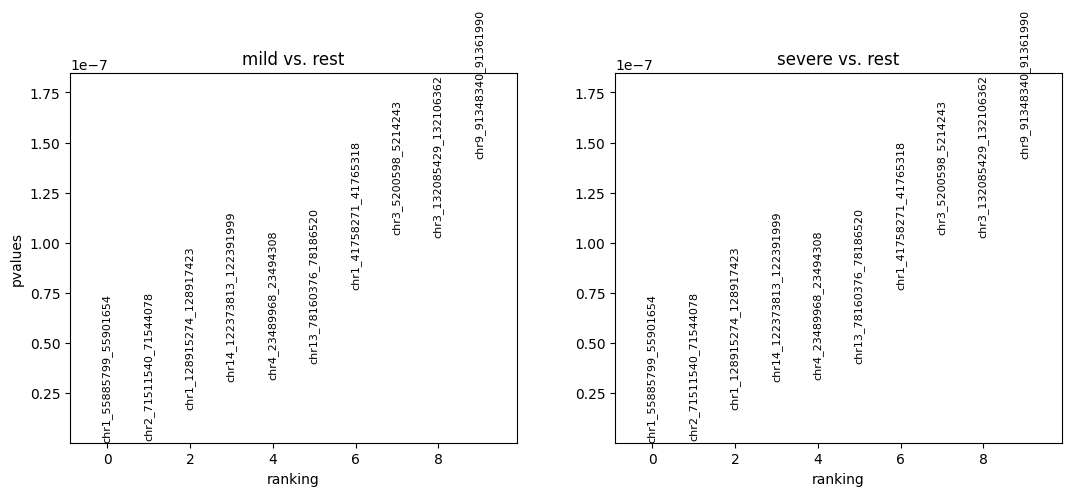

Processing insertion counts for 30_1...
Saving results to Downsampling/fisher_30_1.csv...
30_1: 38 peaks with adj p-value < 0.05

Processing dataset 30_2...
Running Fisher's exact test for 30_2...


100%|██████████| 2/2 [02:25<00:00, 72.88s/it]


Creating rank plot for 30_2...


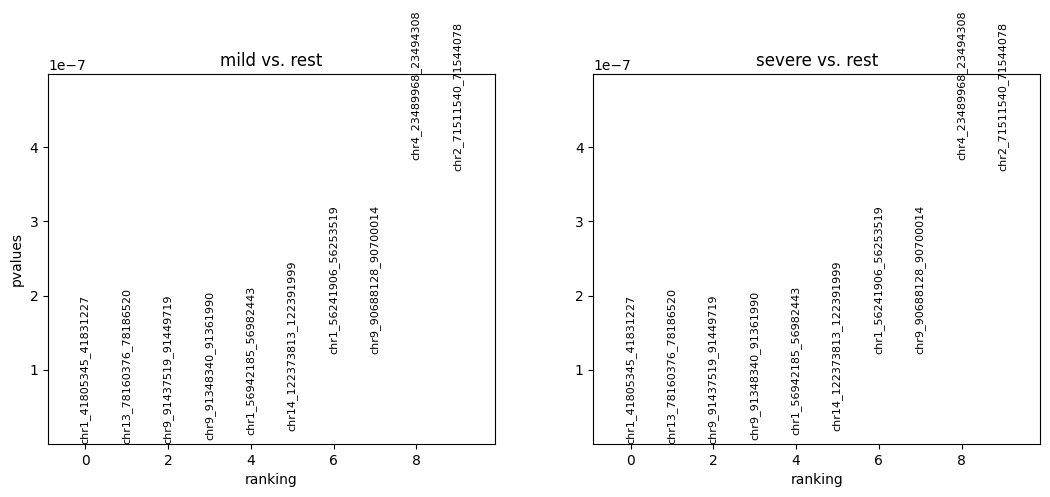

Processing insertion counts for 30_2...
Saving results to Downsampling/fisher_30_2.csv...
30_2: 30 peaks with adj p-value < 0.05

Processing dataset 30_3...
Running Fisher's exact test for 30_3...


100%|██████████| 2/2 [02:15<00:00, 67.86s/it]


Creating rank plot for 30_3...


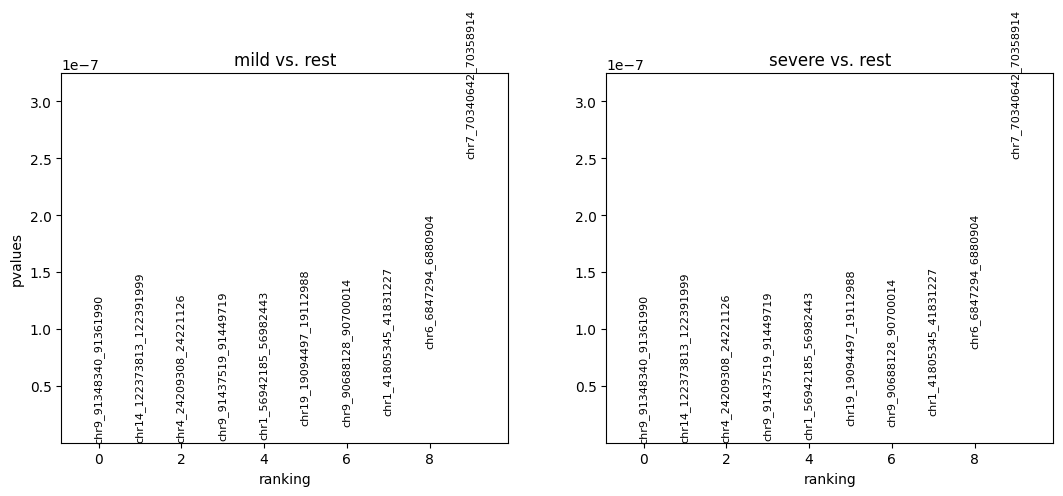

Processing insertion counts for 30_3...
Saving results to Downsampling/fisher_30_3.csv...
30_3: 27 peaks with adj p-value < 0.05

Processing dataset 20_1...
Running Fisher's exact test for 20_1...


100%|██████████| 2/2 [02:05<00:00, 62.98s/it]


Creating rank plot for 20_1...


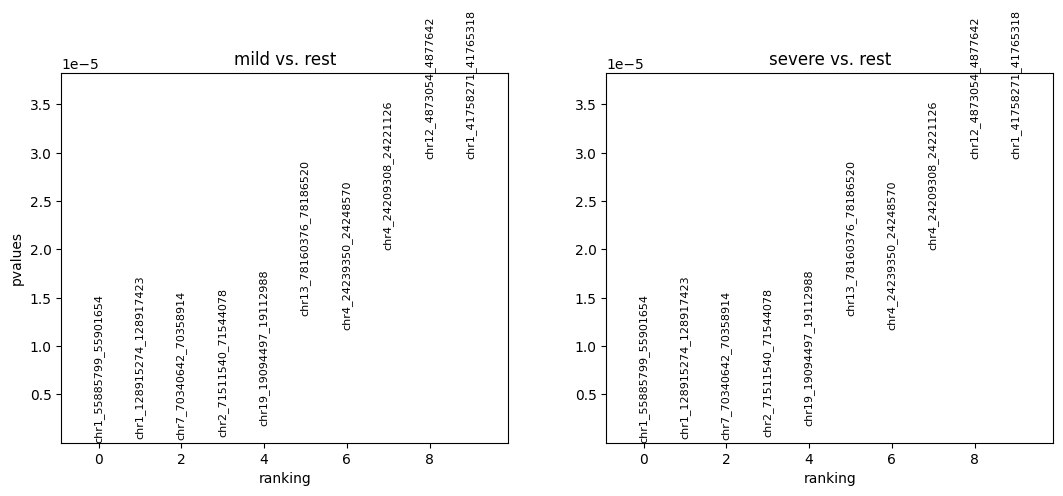

Processing insertion counts for 20_1...
Saving results to Downsampling/fisher_20_1.csv...
20_1: 10 peaks with adj p-value < 0.05

Processing dataset 20_2...
Running Fisher's exact test for 20_2...


100%|██████████| 2/2 [02:07<00:00, 63.55s/it]


Creating rank plot for 20_2...


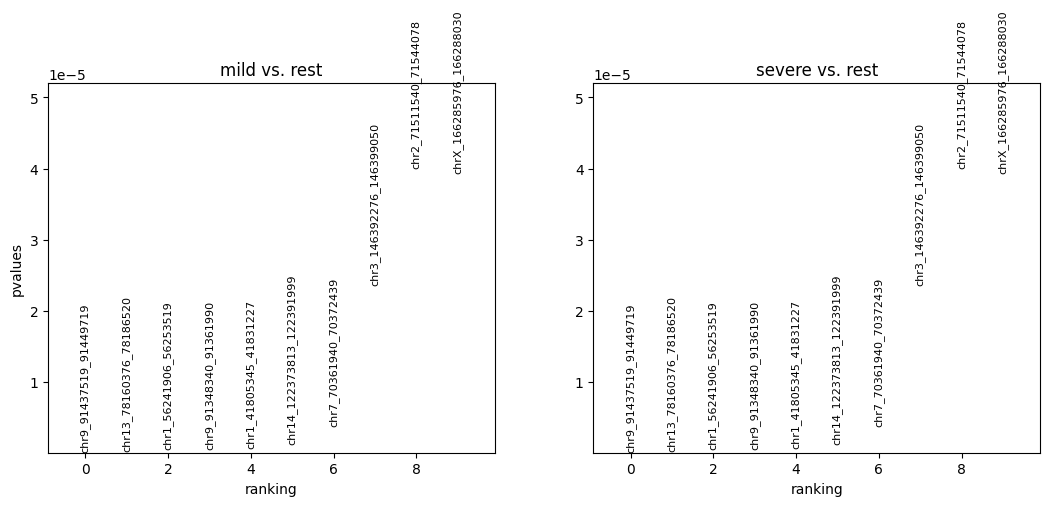

Processing insertion counts for 20_2...
Saving results to Downsampling/fisher_20_2.csv...
20_2: 8 peaks with adj p-value < 0.05

Processing dataset 20_3...
Running Fisher's exact test for 20_3...


100%|██████████| 2/2 [02:07<00:00, 63.78s/it]


Creating rank plot for 20_3...


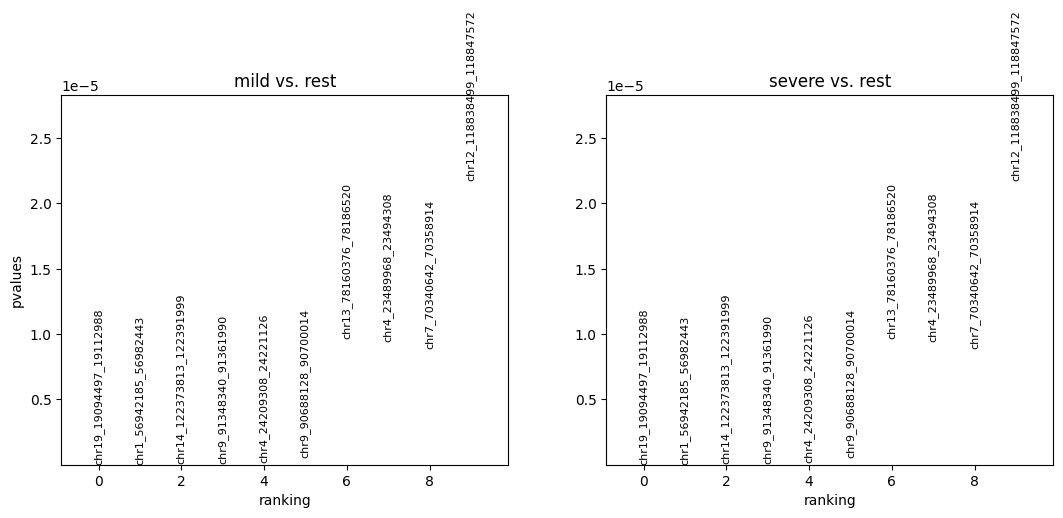

Processing insertion counts for 20_3...
Saving results to Downsampling/fisher_20_3.csv...
20_3: 14 peaks with adj p-value < 0.05


In [33]:
# Run the fisher's exact analysis
significant_peak_counts = analyze_differential_peaks(anndata_objects)

In [34]:
# Create a summary of significant peak counts
summary_df = pd.DataFrame(significant_peak_counts.items(), columns=['Dataset', 'Significant_Peaks'])
summary_df[['Percentage', 'Randomization']] = summary_df['Dataset'].str.split('_', expand=True)
summary_df['Percentage'] = summary_df['Percentage'].astype(int)
summary_df = summary_df.sort_values(['Percentage', 'Randomization'], ascending=[False, True])

# Calculate average significant peaks per percentage
avg_summary = summary_df.groupby('Percentage')['Significant_Peaks'].agg(['mean', 'std', 'min', 'max']).reset_index()
avg_summary.columns = ['Percentage', 'Average_Sig_Peaks', 'StdDev_Sig_Peaks', 'Min_Sig_Peaks', 'Max_Sig_Peaks']

# Save summaries
summary_df.to_csv('Downsampling/significant_peaks_summary.csv', index=False)
avg_summary.to_csv('Downsampling/average_significant_peaks_summary.csv', index=False)

# Print the summary tables
print("\nSummary of Significant Peaks:")
print(summary_df)

print("\nAverage Significant Peaks by Percentage:")
print(avg_summary)


Summary of Significant Peaks:
   Dataset  Significant_Peaks  Percentage Randomization
0     90_1                223          90             1
1     90_2                202          90             2
2     90_3                210          90             3
3     80_1                170          80             1
4     80_2                179          80             2
5     80_3                166          80             3
6     70_1                138          70             1
7     70_2                117          70             2
8     70_3                111          70             3
9     60_1                100          60             1
10    60_2                 91          60             2
11    60_3                 86          60             3
12    50_1                 82          50             1
13    50_2                 71          50             2
14    50_3                 65          50             3
15    40_1                 49          40             1
16    40_2       

In [35]:

def plot_significant_peaks(summary_df, full_data_peaks=243):
    """
    Create a line plot of significant peaks vs downsampling percentage
    
    Parameters:
    -----------
    summary_df : pandas.DataFrame
        DataFrame containing the significant peak counts for each dataset
    full_data_peaks : int
        Number of significant peaks in the 100% (full) dataset
    """
    # Group by percentage and calculate statistics
    grouped_stats = summary_df.groupby('Percentage')['Significant_Peaks'].agg(['mean', 'std', 'count']).reset_index()
    
    # Add the 100% data point
    full_data = pd.DataFrame({
        'Percentage': [100],
        'mean': [full_data_peaks],
        'std': [0],  # No randomization for the full dataset
        'count': [1]
    })
    
    # Combine and sort
    all_data = pd.concat([grouped_stats, full_data]).sort_values('Percentage', ascending=True)
    
    # Calculate standard error for error bars
    all_data['se'] = all_data['std'] / np.sqrt(all_data['count'])
    
    # Set up the plot style
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    # Create the line plot with error bars
    plt.errorbar(
        all_data['Percentage'], 
        all_data['mean'], 
        yerr=all_data['se'], 
        fmt='-o', 
        capsize=5, 
        elinewidth=2, 
        markersize=8,
        color='#1f77b4'
    )
    
    # Add individual points for downsampled datasets
    for percentage in summary_df['Percentage'].unique():
        subset = summary_df[summary_df['Percentage'] == percentage]
        plt.scatter(
            [percentage] * len(subset), 
            subset['Significant_Peaks'], 
            alpha=0.5, 
            color='#1f77b4', 
            s=50
        )
    
    # Highlight the 100% data point
    plt.scatter(100, full_data_peaks, color='red', s=100, zorder=5, label='Full dataset (100%)')
    
    # Customize the plot
    plt.xlabel('Downsampling Percentage', fontsize=14)
    plt.ylabel('Number of Significant Peaks (p-adj < 0.05)', fontsize=14)
    plt.title('Effect of Downsampling on Differential Peak Detection', fontsize=16)
    
    # Set x-axis ticks to include all percentages
    all_percentages = sorted(list(all_data['Percentage'].unique()))
    plt.xticks(all_percentages, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(fontsize=12)
    
    # Annotate the full dataset point
    plt.annotate(
        f'{full_data_peaks} peaks', 
        xy=(100, full_data_peaks), 
        xytext=(100-5, full_data_peaks+20),
        fontsize=12
    )
    
    # Save the figure
    plt.tight_layout()
    plt.savefig('Downsampling/significant_peaks_vs_downsampling.png', dpi=300, bbox_inches='tight')
    plt.savefig('Downsampling/significant_peaks_vs_downsampling.pdf', bbox_inches='tight')
    
    print("Plot saved to 'Downsampling/significant_peaks_vs_downsampling.png' and 'Downsampling/significant_peaks_vs_downsampling.pdf'")
    
    # Show the plot
    plt.show()
    
    # Create a second plot: percentage of peaks retained vs downsampling percentage
    plt.figure(figsize=(10, 6))
    
    # Calculate percentage of retained peaks
    all_data['percent_retained'] = (all_data['mean'] / full_data_peaks) * 100
    all_data['percent_retained_se'] = (all_data['se'] / full_data_peaks) * 100
    
    # Create the line plot
    plt.errorbar(
        all_data['Percentage'], 
        all_data['percent_retained'], 
        yerr=all_data['percent_retained_se'], 
        fmt='-o', 
        capsize=5, 
        elinewidth=2, 
        markersize=8,
        color='#2ca02c'
    )
    
    # Add reference line showing perfect linear relationship
    plt.plot(
        all_data['Percentage'], 
        all_data['Percentage'], 
        '--', 
        color='gray', 
        alpha=0.7,
        label='Linear relationship'
    )
    
    # Add individual points for downsampled datasets
    for percentage in summary_df['Percentage'].unique():
        subset = summary_df[summary_df['Percentage'] == percentage]
        plt.scatter(
            [percentage] * len(subset), 
            (subset['Significant_Peaks'] / full_data_peaks) * 100, 
            alpha=0.5, 
            color='#2ca02c', 
            s=50
        )
    
    # Highlight the 100% data point
    plt.scatter(100, 100, color='red', s=100, zorder=5, label='Full dataset (100%)')
    
    # Customize the plot
    plt.xlabel('Downsampling Percentage', fontsize=14)
    plt.ylabel('Percentage of Significant Peaks Retained', fontsize=14)
    plt.title('Percentage of Differential Peaks Retained vs Downsampling', fontsize=16)
    
    # Set x-axis and y-axis ticks
    plt.xticks(all_percentages, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add legend
    plt.legend(fontsize=12, loc='lower right')
    
    # Save the figure
    plt.tight_layout()
    plt.savefig('Downsampling/percent_peaks_retained_vs_downsampling.png', dpi=300, bbox_inches='tight')
    plt.savefig('Downsampling/percent_peaks_retained_vs_downsampling.pdf', bbox_inches='tight')
    
    print("Percentage retained plot saved to 'Downsampling/percent_peaks_retained_vs_downsampling.png' and 'Downsampling/percent_peaks_retained_vs_downsampling.pdf'")
    
    # Show the plot
    plt.show()

Plot saved to 'Downsampling/significant_peaks_vs_downsampling.png' and 'Downsampling/significant_peaks_vs_downsampling.pdf'


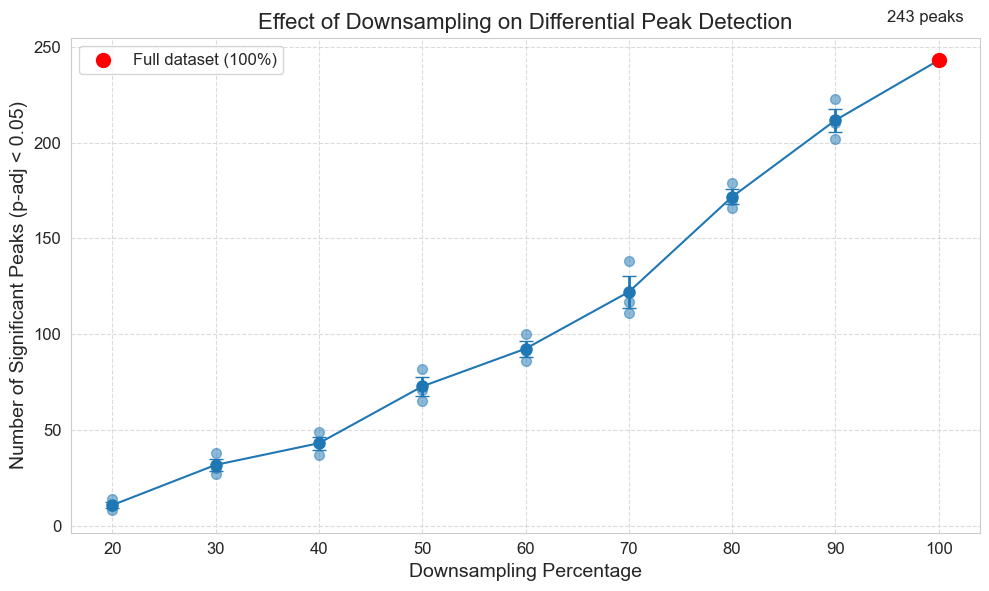

Percentage retained plot saved to 'Downsampling/percent_peaks_retained_vs_downsampling.png' and 'Downsampling/percent_peaks_retained_vs_downsampling.pdf'


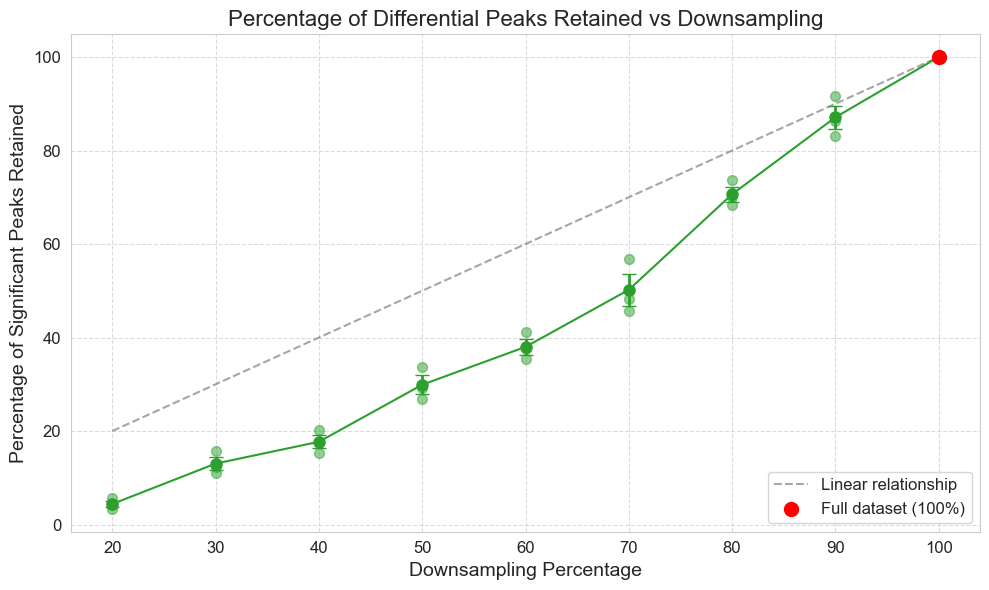

In [36]:
# Run the plotting function
plot_significant_peaks(summary_df, full_data_peaks=243)

In [3]:
# Seizure scores for animals in order:
# 9_4, 3_2, 5_2, 4_3, 1_5, 4_2, 5_1, 16_7, 14_5, 15_7, 7_4, 5_5, 6_5, 3_1, 2_2, 9_5, 8_1, 11_1, 11_5, 16_6
seizure_scores = np.array([1, 1, 2, 2, 2, 2, 3, 2, 3, 3, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8])

In [8]:
def analyze_correlations(filename, start_col=15, end_col=35):  #Start at the first column of insertion counts
    """
    Analyze Spearman correlations between peak insertion counts and seizure scores
    
    Parameters:
    -----------
    filename : str
        Path to the CSV file containing Fisher's exact test results
    start_col : int
        Start index of columns containing insertion counts (column P = index 15)
    end_col : int
        End index of columns containing insertion counts (column P+19 = index 34, exclusive)
    
    Returns:
    --------
    tuple
        (total_sig_peaks, sig_corr_peaks, correlation_dataframe)
    """
    try:
        # Read the data
        data = pd.read_csv(filename, index_col=0)
        
        # Extract dataset info from filename
        match = re.search(r'fisher_(\d+)_(\d+).csv', os.path.basename(filename))
        if match:
            percentage, randomization = match.groups()
            dataset_name = f"{percentage}_{randomization}"
        else:
            dataset_name = os.path.basename(filename).replace("fisher_", "").replace(".csv", "")
        
        print(f"\nProcessing dataset: {dataset_name}")
        
        # Print column info for debugging
        print(f"Total columns: {data.shape[1]}")
        print(f"Columns {start_col} to {end_col} will be used for insertion counts")
        
        # Check if we have enough columns
        if data.shape[1] < end_col:
            print(f"Warning: Data has only {data.shape[1]} columns, but we're trying to access up to column {end_col}")
            print(f"Column names: {list(data.columns)}")
            # Try to automatically detect sample columns
            potential_sample_cols = [col for col in data.columns if re.match(r'\d+_\d+', col)]
            if len(potential_sample_cols) >= 20:
                print(f"Found {len(potential_sample_cols)} potential sample columns")
                # Use these columns instead
                sample_indices = [data.columns.get_loc(col) for col in potential_sample_cols[:20]]
                start_col = min(sample_indices)
                end_col = max(sample_indices) + 1
                print(f"Adjusted to use columns {start_col} to {end_col}")
            else:
                print("Could not automatically detect sample columns")
                return None, None, None
        
        # Create a copy for normalized data
        norm_data = data.copy()
        
        # Calculate normalized counts per million
        norm_counts = data.iloc[:, start_col:end_col].div(data.iloc[:, start_col:end_col].sum(axis=0)) * 1000000
        
        # Replace columns with normalized values
        norm_data.iloc[:, start_col:end_col] = norm_counts
        
        # Check for proper normalization (should be close to 1,000,000)
        norm_sum = norm_data.iloc[:, start_col].sum()
        print(f"Sum of normalized counts for first sample: {norm_sum:.2f}")
        
        # Filter significant peaks (check column name based on your dataset)
        if 'pvalues_adj' in norm_data.columns:
            sig_column = 'pvalues_adj'
        elif 'fisher_pval_adj' in norm_data.columns:
            sig_column = 'fisher_pval_adj'
        else:
            # Try to find an appropriate column name
            possible_cols = [col for col in norm_data.columns if 'adj' in col.lower() and 'pval' in col.lower()]
            if possible_cols:
                sig_column = possible_cols[0]
                print(f"Using column {sig_column} for significance filtering")
            else:
                # One last attempt - look for columns with p-value in name
                possible_cols = [col for col in norm_data.columns if 'pval' in col.lower()]
                if possible_cols:
                    sig_column = possible_cols[0]
                    print(f"Using column {sig_column} for significance filtering")
                else:
                    print("Could not find adjusted p-value column, please check column names")
                    print(f"Available columns: {list(norm_data.columns)}")
                    return None, None, None
        
        # Get significant peaks
        norm_data_sig = norm_data[norm_data[sig_column] < 0.05]
        total_sig_peaks = len(norm_data_sig)
        print(f"Number of significant peaks: {total_sig_peaks}")
        
        if total_sig_peaks == 0:
            print("No significant peaks found, skipping correlation analysis")
            return total_sig_peaks, 0, None
        
        # Get normalized insertion counts for significant peaks
        sig_norm_counts = norm_data_sig.iloc[:, start_col:end_col]
        
        # Prepare data for correlation
        Y = seizure_scores
        X = np.array(sig_norm_counts).T
        
        print(f"X shape for correlation: {X.shape}")
        
        # Calculate Spearman correlations
        result_sp_corr_norm = []
        for i in range(X.shape[1]):
            result_sp_corr_norm.append([
                stats.spearmanr(X[:,i], Y)[0],
                stats.spearmanr(X[:,i], Y)[1]
            ])
        
        # Create correlation dataframe
        sp_corr_norm = pd.DataFrame(
            result_sp_corr_norm,
            columns=['sp_corr_norm', 'sp_corr_norm_pvalue'], 
            index=sig_norm_counts.index
        )
        
        # Apply FDR correction
        rejected, padj = fdrcorrection(sp_corr_norm['sp_corr_norm_pvalue'], alpha=0.05)
        sp_corr_norm['sp_corr_norm_padj'] = padj
        
        # Count significant correlations
        sig_corr_peaks = sum(padj < 0.05)
        print(f"Number of peaks with significant correlation: {sig_corr_peaks}")
        
        # Combine data
        sig_corr_data = pd.concat([norm_data_sig, sp_corr_norm], axis=1)
        
        # Save to file
        output_file = os.path.join('Downsampling', f'sig_corr_{dataset_name}.csv')
        sig_corr_data.to_csv(output_file)
        print(f"Results saved to {output_file}")
        
        return total_sig_peaks, sig_corr_peaks, sig_corr_data
        
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

In [9]:
# Find all Fisher exact test result files
fisher_files = []
for file in os.listdir('Downsampling'):
    if file.startswith('fisher_') and file.endswith('.csv'):
        fisher_files.append(os.path.join('Downsampling', file))

In [10]:
fisher_files

['Downsampling/fisher_30_2.csv',
 'Downsampling/fisher_30_3.csv',
 'Downsampling/fisher_30_1.csv',
 'Downsampling/fisher_70_3.csv',
 'Downsampling/fisher_70_2.csv',
 'Downsampling/fisher_70_1.csv',
 'Downsampling/fisher_90_1.csv',
 'Downsampling/fisher_50_1.csv',
 'Downsampling/fisher_50_3.csv',
 'Downsampling/fisher_90_3.csv',
 'Downsampling/fisher_90_2.csv',
 'Downsampling/fisher_50_2.csv',
 'Downsampling/fisher_20_1.csv',
 'Downsampling/fisher_20_3.csv',
 'Downsampling/fisher_20_2.csv',
 'Downsampling/fisher_60_1.csv',
 'Downsampling/fisher_60_2.csv',
 'Downsampling/fisher_60_3.csv',
 'Downsampling/fisher_80_2.csv',
 'Downsampling/fisher_40_2.csv',
 'Downsampling/fisher_40_3.csv',
 'Downsampling/fisher_80_3.csv',
 'Downsampling/fisher_80_1.csv',
 'Downsampling/fisher_40_1.csv']

In [11]:
# Process all files and collect results for Spearman correlations
results = []

for file in fisher_files:
    total_sig_peaks, sig_corr_peaks, _ = analyze_correlations(file)
    
    if total_sig_peaks is not None:
        # Extract percentage and randomization from filename
        match = re.search(r'fisher_(\d+)_(\d+).csv', os.path.basename(file))
        if match:
            percentage, randomization = match.groups()
            results.append({
                'Percentage': int(percentage),
                'Randomization': int(randomization),
                'Sig_Peaks': total_sig_peaks,
                'Sig_Corr_Peaks': sig_corr_peaks,
                'Percent_Correlated': (sig_corr_peaks / total_sig_peaks * 100) if total_sig_peaks > 0 else 0
            })


Processing dataset: 30_2
Total columns: 34
Columns 15 to 35 will be used for insertion counts
Column names: ['Chr', 'Start', 'End', 'Reads', 'Direction', 'Barcodes', 'logfoldchanges', 'pvalues', 'pvalues_adj', 'number', 'number_rest', 'total', 'total_rest', 'group', '9_4', '3_2', '5_2', '4_3', '1_5', '4_2', '5_1', '16_7', '14_5', '15_7', '7_4', '5_5', '6_5', '3_1', '2_2', '9_5', '8_1', '11_1', '11_5', '16_6']
Found 20 potential sample columns
Adjusted to use columns 14 to 34
Sum of normalized counts for first sample: 1000000.00
Number of significant peaks: 30
X shape for correlation: (20, 30)
Number of peaks with significant correlation: 1
Results saved to Downsampling/sig_corr_30_2.csv

Processing dataset: 30_3
Total columns: 34
Columns 15 to 35 will be used for insertion counts
Column names: ['Chr', 'Start', 'End', 'Reads', 'Direction', 'Barcodes', 'logfoldchanges', 'pvalues', 'pvalues_adj', 'number', 'number_rest', 'total', 'total_rest', 'group', '9_4', '3_2', '5_2', '4_3', '1_5', 

Sum of normalized counts for first sample: 1000000.00
Number of significant peaks: 202
X shape for correlation: (20, 202)
Number of peaks with significant correlation: 16
Results saved to Downsampling/sig_corr_90_2.csv

Processing dataset: 50_2
Total columns: 34
Columns 15 to 35 will be used for insertion counts
Column names: ['Chr', 'Start', 'End', 'Reads', 'Direction', 'Barcodes', 'logfoldchanges', 'pvalues', 'pvalues_adj', 'number', 'number_rest', 'total', 'total_rest', 'group', '9_4', '3_2', '5_2', '4_3', '1_5', '4_2', '5_1', '16_7', '14_5', '15_7', '7_4', '5_5', '6_5', '3_1', '2_2', '9_5', '8_1', '11_1', '11_5', '16_6']
Found 20 potential sample columns
Adjusted to use columns 14 to 34
Sum of normalized counts for first sample: 1000000.00
Number of significant peaks: 71
X shape for correlation: (20, 71)
Number of peaks with significant correlation: 0
Results saved to Downsampling/sig_corr_50_2.csv

Processing dataset: 20_1
Total columns: 34
Columns 15 to 35 will be used for insert

Number of peaks with significant correlation: 11
Results saved to Downsampling/sig_corr_80_3.csv

Processing dataset: 80_1
Total columns: 34
Columns 15 to 35 will be used for insertion counts
Column names: ['Chr', 'Start', 'End', 'Reads', 'Direction', 'Barcodes', 'logfoldchanges', 'pvalues', 'pvalues_adj', 'number', 'number_rest', 'total', 'total_rest', 'group', '9_4', '3_2', '5_2', '4_3', '1_5', '4_2', '5_1', '16_7', '14_5', '15_7', '7_4', '5_5', '6_5', '3_1', '2_2', '9_5', '8_1', '11_1', '11_5', '16_6']
Found 20 potential sample columns
Adjusted to use columns 14 to 34
Sum of normalized counts for first sample: 1000000.00
Number of significant peaks: 170
X shape for correlation: (20, 170)
Number of peaks with significant correlation: 15
Results saved to Downsampling/sig_corr_80_1.csv

Processing dataset: 40_1
Total columns: 34
Columns 15 to 35 will be used for insertion counts
Column names: ['Chr', 'Start', 'End', 'Reads', 'Direction', 'Barcodes', 'logfoldchanges', 'pvalues', 'pvalue

In [13]:
# test on full dataset
analyze_correlations("Downsampling/fisher_100_1.csv",start_col=40, end_col=60)


Processing dataset: 100_1
Total columns: 60
Columns 40 to 60 will be used for insertion counts
Sum of normalized counts for first sample: 1000000.00
Number of significant peaks: 243
X shape for correlation: (20, 243)
Number of peaks with significant correlation: 15
Results saved to Downsampling/sig_corr_100_1.csv


(243,
 15,
                             Chr      Start        End  peak length  \
 chr1_6730562_6739058       chr1    6730562    6739058         8496   
 chr1_18971914_18981320     chr1   18971914   18981320         9406   
 chr1_41119405_41125967     chr1   41119405   41125967         6562   
 chr1_41150335_41159059     chr1   41150335   41159059         8724   
 chr1_41426863_41430661     chr1   41426863   41430661         3798   
 ...                         ...        ...        ...          ...   
 chr19_27803048_27804980   chr19   27803048   27804980         1932   
 chrX_10485314_10491000     chrX   10485314   10491000         5686   
 chrX_23277257_23298329     chrX   23277257   23298329        21072   
 chrX_146957984_146964314   chrX  146957984  146964314         6330   
 chrX_161720025_161729572   chrX  161720025  161729572         9547   
 
                          Nearest Refseq1 Gene Name1 Direction1  Distance1  \
 chr1_6730562_6739058        NM_001244693       St18     

In [14]:
# Add the 100% dataset result
results.append({
    'Percentage': 100,
    'Randomization': 1,
    'Sig_Peaks': 243,  # From your full dataset
    'Sig_Corr_Peaks': 15,  # From your full dataset
    'Percent_Correlated': (15 / 243 * 100)
})

# Create summary dataframe
summary_df = pd.DataFrame(results)
summary_df.sort_values(['Percentage', 'Randomization'], ascending=[False, True], inplace=True)

# Save summary
summary_df.to_csv('Downsampling/correlation_summary.csv', index=False)
print("\nSummary saved to 'Downsampling/correlation_summary.csv'")

# Create summary by percentage
summary_by_percentage = summary_df.groupby('Percentage').agg({
    'Sig_Peaks': ['mean', 'std'],
    'Sig_Corr_Peaks': ['mean', 'std'],
    'Percent_Correlated': ['mean', 'std']
}).reset_index()

# Flatten multi-level columns
summary_by_percentage.columns = ['_'.join(col).strip('_') for col in summary_by_percentage.columns.values]

# Save percentage summary
summary_by_percentage.to_csv('Downsampling/correlation_summary_by_percentage.csv', index=False)
print("Percentage summary saved to 'Downsampling/correlation_summary_by_percentage.csv'")


Summary saved to 'Downsampling/correlation_summary.csv'
Percentage summary saved to 'Downsampling/correlation_summary_by_percentage.csv'


In [4]:
# read file
summary_df = pd.read_csv('Downsampling/correlation_summary.csv')
summary_df

,Percentage,Randomization,Sig_Peaks,Sig_Corr_Peaks,Percent_Correlated
0,100,1,243,15,6.172840
1,90,1,223,21,9.417040
2,90,2,202,16,7.920792
3,90,3,210,11,5.238095
4,80,1,170,15,8.823529
5,80,2,179,21,11.731844
6,80,3,166,11,6.626506
7,70,1,138,2,1.449275
8,70,2,117,5,4.273504
9,70,3,111,4,3.603604


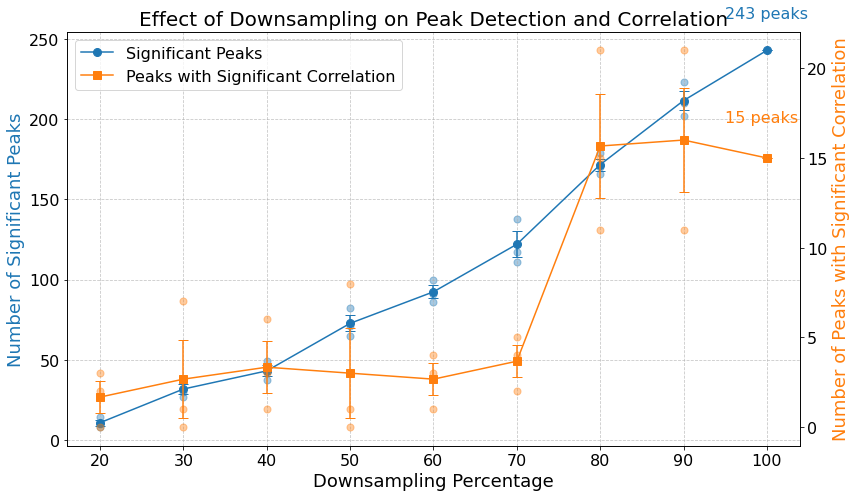

In [9]:
# Create visualizations

# Plot 1: Number of significant peaks and correlated peaks vs downsampling percentage
plt.figure(figsize=(12, 7))

# Group by percentage for plotting
plot_data = summary_df.groupby('Percentage').agg({
    'Sig_Peaks': ['mean', 'std'],
    'Sig_Corr_Peaks': ['mean', 'std']
}).reset_index()

# Flatten column names
plot_data.columns = ['_'.join(col).strip('_') for col in plot_data.columns.values]

# Calculate standard errors
plot_data['Sig_Peaks_se'] = plot_data['Sig_Peaks_std'] / np.sqrt(3)  # assuming 3 randomizations per percentage
plot_data['Sig_Corr_Peaks_se'] = plot_data['Sig_Corr_Peaks_std'] / np.sqrt(3)

# For 100% data, we need to handle differently (no randomization)
plot_data.loc[plot_data['Percentage'] == 100, ['Sig_Peaks_se', 'Sig_Corr_Peaks_se']] = 0

# Sort by percentage
plot_data = plot_data.sort_values('Percentage')

# Primary y-axis for significant peaks
ax1 = plt.subplot(111)
ax1.tick_params(axis='both', labelsize=16)
line1 = ax1.errorbar(
    plot_data['Percentage'], 
    plot_data['Sig_Peaks_mean'], 
    yerr=plot_data['Sig_Peaks_se'],
    marker='o',
    markersize=8,
    capsize=5,
    label='Significant Peaks',
    color='#1f77b4'
)

# Add individual points for downsampled datasets
for percentage in summary_df['Percentage'].unique():
    if percentage != 100:  # Skip 100% as it has only one data point
        subset = summary_df[summary_df['Percentage'] == percentage]
        ax1.scatter(
            [percentage] * len(subset), 
            subset['Sig_Peaks'], 
            alpha=0.4, 
            color='#1f77b4', 
            s=50
        )

# Secondary y-axis for correlated peaks
ax2 = ax1.twinx()
ax2.tick_params(axis='both', labelsize=16)
line2 = ax2.errorbar(
    plot_data['Percentage'], 
    plot_data['Sig_Corr_Peaks_mean'], 
    yerr=plot_data['Sig_Corr_Peaks_se'],
    marker='s',
    markersize=8,
    capsize=5,
    label='Peaks with Significant Correlation',
    color='#ff7f0e'
)

# Add individual points for downsampled datasets
for percentage in summary_df['Percentage'].unique():
    if percentage != 100:
        subset = summary_df[summary_df['Percentage'] == percentage]
        ax2.scatter(
            [percentage] * len(subset), 
            subset['Sig_Corr_Peaks'], 
            alpha=0.4, 
            color='#ff7f0e', 
            s=50
        )

# Set x-axis ticks
all_percentages = sorted(list(plot_data['Percentage'].unique()))
ax1.set_xticks(all_percentages)

# Add labels and title
ax1.set_xlabel('Downsampling Percentage', fontsize=18)
ax1.set_ylabel('Number of Significant Peaks', color='#1f77b4', fontsize=18)
ax2.set_ylabel('Number of Peaks with Significant Correlation', color='#ff7f0e', fontsize=18)
plt.title('Effect of Downsampling on Peak Detection and Correlation', fontsize=20)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Fix for the legend issue - use correct way to get handles from errorbar plots
ax1_handle = line1[0]  # The first element of the tuple is the Line2D object
ax2_handle = line2[0]  # The first element of the tuple is the Line2D object

# Create legend with both handles
ax1.legend([ax1_handle, ax2_handle], 
           ['Significant Peaks', 'Peaks with Significant Correlation'], 
           loc='upper left', fontsize=16)

# Annotate the full dataset point for significant peaks
ax1.annotate(
    f'{plot_data.loc[plot_data["Percentage"] == 100, "Sig_Peaks_mean"].values[0]:.0f} peaks', 
    xy=(100, plot_data.loc[plot_data["Percentage"] == 100, "Sig_Peaks_mean"].values[0]), 
    xytext=(95, plot_data.loc[plot_data["Percentage"] == 100, "Sig_Peaks_mean"].values[0] + 20),
    fontsize=16,
    color='#1f77b4'
)

# Annotate the full dataset point for correlated peaks
ax2.annotate(
    f'{plot_data.loc[plot_data["Percentage"] == 100, "Sig_Corr_Peaks_mean"].values[0]:.0f} peaks', 
    xy=(100, plot_data.loc[plot_data["Percentage"] == 100, "Sig_Corr_Peaks_mean"].values[0]), 
    xytext=(95, plot_data.loc[plot_data["Percentage"] == 100, "Sig_Corr_Peaks_mean"].values[0] + 2),
    fontsize=16,
    color='#ff7f0e'
)

# Save figure
plt.tight_layout()
#plt.savefig('Downsampling/sig_peaks_and_correlations.png', dpi=300, bbox_inches='tight')
plt.savefig('Downsampling/sig_peaks_and_correlations_v4.pdf', bbox_inches='tight')
plt.show()